In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!cp -r "/gdrive/My Drive/Santander" /content

In [2]:
"""
Code based on BreakfastPirate Forum post
__author__ : SRK
"""
import csv
import datetime
from operator import sub
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing, ensemble
from tqdm import tqdm

mapping_dict = {
'ind_empleado'  : {-99:0, 'N':1, 'B':2, 'F':3, 'A':4, 'S':5},
'sexo'          : {'V':0, 'H':1, -99:2},
'ind_nuevo'     : {'0':0, '1':1, -99:2},
'indrel'        : {'1':0, '99':1, -99:2},
'indrel_1mes'   : {-99:0, '1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':5},
'tiprel_1mes'   : {-99:0, 'I':1, 'A':2, 'P':3, 'R':4, 'N':5},
'indresi'       : {-99:0, 'S':1, 'N':2},
'indext'        : {-99:0, 'S':1, 'N':2},
'conyuemp'      : {-99:0, 'S':1, 'N':2},
'indfall'       : {-99:0, 'S':1, 'N':2},
'tipodom'       : {-99:0, '1':1},
'ind_actividad_cliente' : {'0':0, '1':1, -99:2},
'segmento'      : {'02 - PARTICULARES':0, '03 - UNIVERSITARIO':1, '01 - TOP':2, -99:2},
'pais_residencia' : {'LV': 102, 'BE': 12, 'BG': 50, 'BA': 61, 'BM': 117, 'BO': 62, 'JP': 82, 'JM': 116, 'BR': 17, 'BY': 64, 'BZ': 113, 'RU': 43, 'RS': 89, 'RO': 41, 'GW': 99, 'GT': 44, 'GR': 39, 'GQ': 73, 'GE': 78, 'GB': 9, 'GA': 45, 'GN': 98, 'GM': 110, 'GI': 96, 'GH': 88, 'OM': 100, 'HR': 67, 'HU': 106, 'HK': 34, 'HN': 22, 'AD': 35, 'PR': 40, 'PT': 26, 'PY': 51, 'PA': 60, 'PE': 20, 'PK': 84, 'PH': 91, 'PL': 30, 'EE': 52, 'EG': 74, 'ZA': 75, 'EC': 19, 'AL': 25, 'VN': 90, 'ET': 54, 'ZW': 114, 'ES': 0, 'MD': 68, 'UY': 77, 'MM': 94, 'ML': 104, 'US': 15, 'MT': 118, 'MR': 48, 'UA': 49, 'MX': 16, 'IL': 42, 'FR': 8, 'MA': 38, 'FI': 23, 'NI': 33, 'NL': 7, 'NO': 46, 'NG': 83, 'NZ': 93, 'CI': 57, 'CH': 3, 'CO': 21, 'CN': 28, 'CM': 55, 'CL': 4, 'CA': 2, 'CG': 101, 'CF': 109, 'CD': 112, 'CZ': 36, 'CR': 32, 'CU': 72, 'KE': 65, 'KH': 95, 'SV': 53, 'SK': 69, 'KR': 87, 'KW': 92, 'SN': 47, 'SL': 97, 'KZ': 111, 'SA': 56, 'SG': 66, 'SE': 24, 'DO': 11, 'DJ': 115, 'DK': 76, 'DE': 10, 'DZ': 80, 'MK': 105, -99: 1, 'LB': 81, 'TW': 29, 'TR': 70, 'TN': 85, 'LT': 103, 'LU': 59, 'TH': 79, 'TG': 86, 'LY': 108, 'AE': 37, 'VE': 14, 'IS': 107, 'IT': 18, 'AO': 71, 'AR': 13, 'AU': 63, 'AT': 6, 'IN': 31, 'IE': 5, 'QA': 58, 'MZ': 27},
'canal_entrada' : {'013': 49, 'KHP': 160, 'KHQ': 157, 'KHR': 161, 'KHS': 162, 'KHK': 10, 'KHL': 0, 'KHM': 12, 'KHN': 21, 'KHO': 13, 'KHA': 22, 'KHC': 9, 'KHD': 2, 'KHE': 1, 'KHF': 19, '025': 159, 'KAC': 57, 'KAB': 28, 'KAA': 39, 'KAG': 26, 'KAF': 23, 'KAE': 30, 'KAD': 16, 'KAK': 51, 'KAJ': 41, 'KAI': 35, 'KAH': 31, 'KAO': 94, 'KAN': 110, 'KAM': 107, 'KAL': 74, 'KAS': 70, 'KAR': 32, 'KAQ': 37, 'KAP': 46, 'KAW': 76, 'KAV': 139, 'KAU': 142, 'KAT': 5, 'KAZ': 7, 'KAY': 54, 'KBJ': 133, 'KBH': 90, 'KBN': 122, 'KBO': 64, 'KBL': 88, 'KBM': 135, 'KBB': 131, 'KBF': 102, 'KBG': 17, 'KBD': 109, 'KBE': 119, 'KBZ': 67, 'KBX': 116, 'KBY': 111, 'KBR': 101, 'KBS': 118, 'KBP': 121, 'KBQ': 62, 'KBV': 100, 'KBW': 114, 'KBU': 55, 'KCE': 86, 'KCD': 85, 'KCG': 59, 'KCF': 105, 'KCA': 73, 'KCC': 29, 'KCB': 78, 'KCM': 82, 'KCL': 53, 'KCO': 104, 'KCN': 81, 'KCI': 65, 'KCH': 84, 'KCK': 52, 'KCJ': 156, 'KCU': 115, 'KCT': 112, 'KCV': 106, 'KCQ': 154, 'KCP': 129, 'KCS': 77, 'KCR': 153, 'KCX': 120, 'RED': 8, 'KDL': 158, 'KDM': 130, 'KDN': 151, 'KDO': 60, 'KDH': 14, 'KDI': 150, 'KDD': 113, 'KDE': 47, 'KDF': 127, 'KDG': 126, 'KDA': 63, 'KDB': 117, 'KDC': 75, 'KDX': 69, 'KDY': 61, 'KDZ': 99, 'KDT': 58, 'KDU': 79, 'KDV': 91, 'KDW': 132, 'KDP': 103, 'KDQ': 80, 'KDR': 56, 'KDS': 124, 'K00': 50, 'KEO': 96, 'KEN': 137, 'KEM': 155, 'KEL': 125, 'KEK': 145, 'KEJ': 95, 'KEI': 97, 'KEH': 15, 'KEG': 136, 'KEF': 128, 'KEE': 152, 'KED': 143, 'KEC': 66, 'KEB': 123, 'KEA': 89, 'KEZ': 108, 'KEY': 93, 'KEW': 98, 'KEV': 87, 'KEU': 72, 'KES': 68, 'KEQ': 138, -99: 6, 'KFV': 48, 'KFT': 92, 'KFU': 36, 'KFR': 144, 'KFS': 38, 'KFP': 40, 'KFF': 45, 'KFG': 27, 'KFD': 25, 'KFE': 148, 'KFB': 146, 'KFC': 4, 'KFA': 3, 'KFN': 42, 'KFL': 34, 'KFM': 141, 'KFJ': 33, 'KFK': 20, 'KFH': 140, 'KFI': 134, '007': 71, '004': 83, 'KGU': 149, 'KGW': 147, 'KGV': 43, 'KGY': 44, 'KGX': 24, 'KGC': 18, 'KGN': 11}
}
cat_cols = list(mapping_dict.keys())

target_cols = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
target_cols = target_cols[2:]

def getTarget(row):
	tlist = []
	for col in target_cols:
		if row[col].strip() in ['', 'NA']:
			target = 0
		else:
			target = int(float(row[col]))
		tlist.append(target)
	return tlist

def getIndex(row, col):
	val = row[col].strip()
	if val not in ['','NA']:
		ind = mapping_dict[col][val]
	else:
		ind = mapping_dict[col][-99]
	return ind

def getAge(row):
	mean_age = 40.
	min_age = 20.
	max_age = 90.
	range_age = max_age - min_age
	age = row['age'].strip()
	if age == 'NA' or age == '':
		age = mean_age
	else:
		age = float(age)
		if age < min_age:
			age = min_age
		elif age > max_age:
			age = max_age
	return round( (age - min_age) / range_age, 4)

def getCustSeniority(row):
	min_value = 0.
	max_value = 256.
	range_value = max_value - min_value
	missing_value = 0.
	cust_seniority = row['antiguedad'].strip()
	if cust_seniority == 'NA' or cust_seniority == '':
		cust_seniority = missing_value
	else:
		cust_seniority = float(cust_seniority)
		if cust_seniority < min_value:
			cust_seniority = min_value
		elif cust_seniority > max_value:
			cust_seniority = max_value
	return round((cust_seniority-min_value) / range_value, 4)

def getRent(row):
	min_value = 0.
	max_value = 1500000.
	range_value = max_value - min_value
	missing_value = 101850.
	rent = row['renta'].strip()
	if rent == 'NA' or rent == '':
		rent = missing_value
	else:
		rent = float(rent)
		if rent < min_value:
			rent = min_value
		elif rent > max_value:
			rent = max_value
	return round((rent-min_value) / range_value, 6)

def processData(in_file_name, cust_dict):
	x_vars_list = []
	y_vars_list = []
	for row in tqdm(csv.DictReader(in_file_name)):
		# use only the four months as specified by breakfastpirate #
		if row['fecha_dato'] not in ['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28']:
			continue

		cust_id = int(row['ncodpers'])
		if row['fecha_dato'] in ['2015-05-28', '2016-05-28']:	
			target_list = getTarget(row)
			cust_dict[cust_id] =  target_list[:]
			continue

		x_vars = []
		for col in cat_cols:
			x_vars.append( getIndex(row, col) )
		x_vars.append( getAge(row) )
		x_vars.append( getCustSeniority(row) )
		x_vars.append( getRent(row) )

		if row['fecha_dato'] == '2016-06-28':
			prev_target_list = cust_dict.get(cust_id, [0]*22)
			x_vars_list.append(x_vars + prev_target_list)
		elif row['fecha_dato'] == '2015-06-28':
			prev_target_list = cust_dict.get(cust_id, [0]*22)
			target_list = getTarget(row)
			new_products = [max(x1 - x2,0) for (x1, x2) in zip(target_list, prev_target_list)]
			if sum(new_products) > 0:
				for ind, prod in enumerate(new_products):
					if prod>0:
						assert len(prev_target_list) == 22
						x_vars_list.append(x_vars+prev_target_list)
						y_vars_list.append(ind)

	return x_vars_list, y_vars_list, cust_dict
			
def runXGB(train_X, train_y, seed_val=0):
	param = {}
	param['objective'] = 'multi:softprob'
	param['eta'] = 0.05
	param['max_depth'] = 8
	param['verbosity'] = 2
	param['num_class'] = 22
	param['eval_metric'] = "mlogloss"
	param['min_child_weight'] = 1
	param['subsample'] = 0.7
	param['colsample_bytree'] = 0.7
	param['seed'] = seed_val
	num_rounds = 50

	plst = list(param.items())
	xgtrain = xgb.DMatrix(train_X, label=train_y)
	model = xgb.train(plst, xgtrain, num_rounds)	
	return model


start_time = datetime.datetime.now()
data_path = "/content/Santander/"
train_file =  open(data_path + "train_ver2.csv")
x_vars_list, y_vars_list, cust_dict = processData(train_file, {})
train_X = np.array(x_vars_list)
train_y = np.array(y_vars_list)
print(np.unique(train_y))
del x_vars_list, y_vars_list
train_file.close()
print(train_X.shape, train_y.shape)
print(datetime.datetime.now()-start_time)
test_file = open(data_path + "test_ver2.csv")
x_vars_list, y_vars_list, cust_dict = processData(test_file, cust_dict)
test_X = np.array(x_vars_list)
del x_vars_list
test_file.close()
print(test_X.shape)
print(datetime.datetime.now()-start_time)



13647309it [02:59, 75986.55it/s]
5776it [00:00, 57745.19it/s]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
(45679, 40) (45679,)
0:02:59.790653


929615it [00:16, 55450.96it/s]


(929615, 40)
0:03:19.980830


In [3]:
print("Building model..")
model = runXGB(train_X, train_y, seed_val=0)
del train_X, train_y
print("Predicting..")
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)
del test_X, xgtest
print(datetime.datetime.now()-start_time)

print("Getting the top products..")
target_cols = np.array(target_cols)
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:,:7]
test_id = np.array(pd.read_csv(data_path + "test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]
out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})
out_df.to_csv('sub_xgb_new.csv', index=False)
print(datetime.datetime.now()-start_time)

Building model..
[09:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 204 extra nodes, 0 pruned nodes, max_depth=8
[09:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 0 pruned nodes, max_depth=0
[09:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=8
[09:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 extra nodes, 0 pruned nodes, max_depth=6
[09:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 158 extra nodes, 0 pruned nodes, max_depth=8
[09:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=8
[09:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=8
[09:24:59] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 

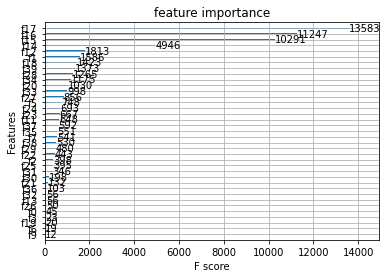

In [4]:
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.title("feature importance")
plt.show()

In [17]:
%pip install shap

     |████████████████████████████████| 276kB 7.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394120 sha256=772509b9c3903da739fbcca9f142fc51444282ae180d84cd870e4938c6af79bc
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [15]:
import shap
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(model)

ModuleNotFoundError: ignored

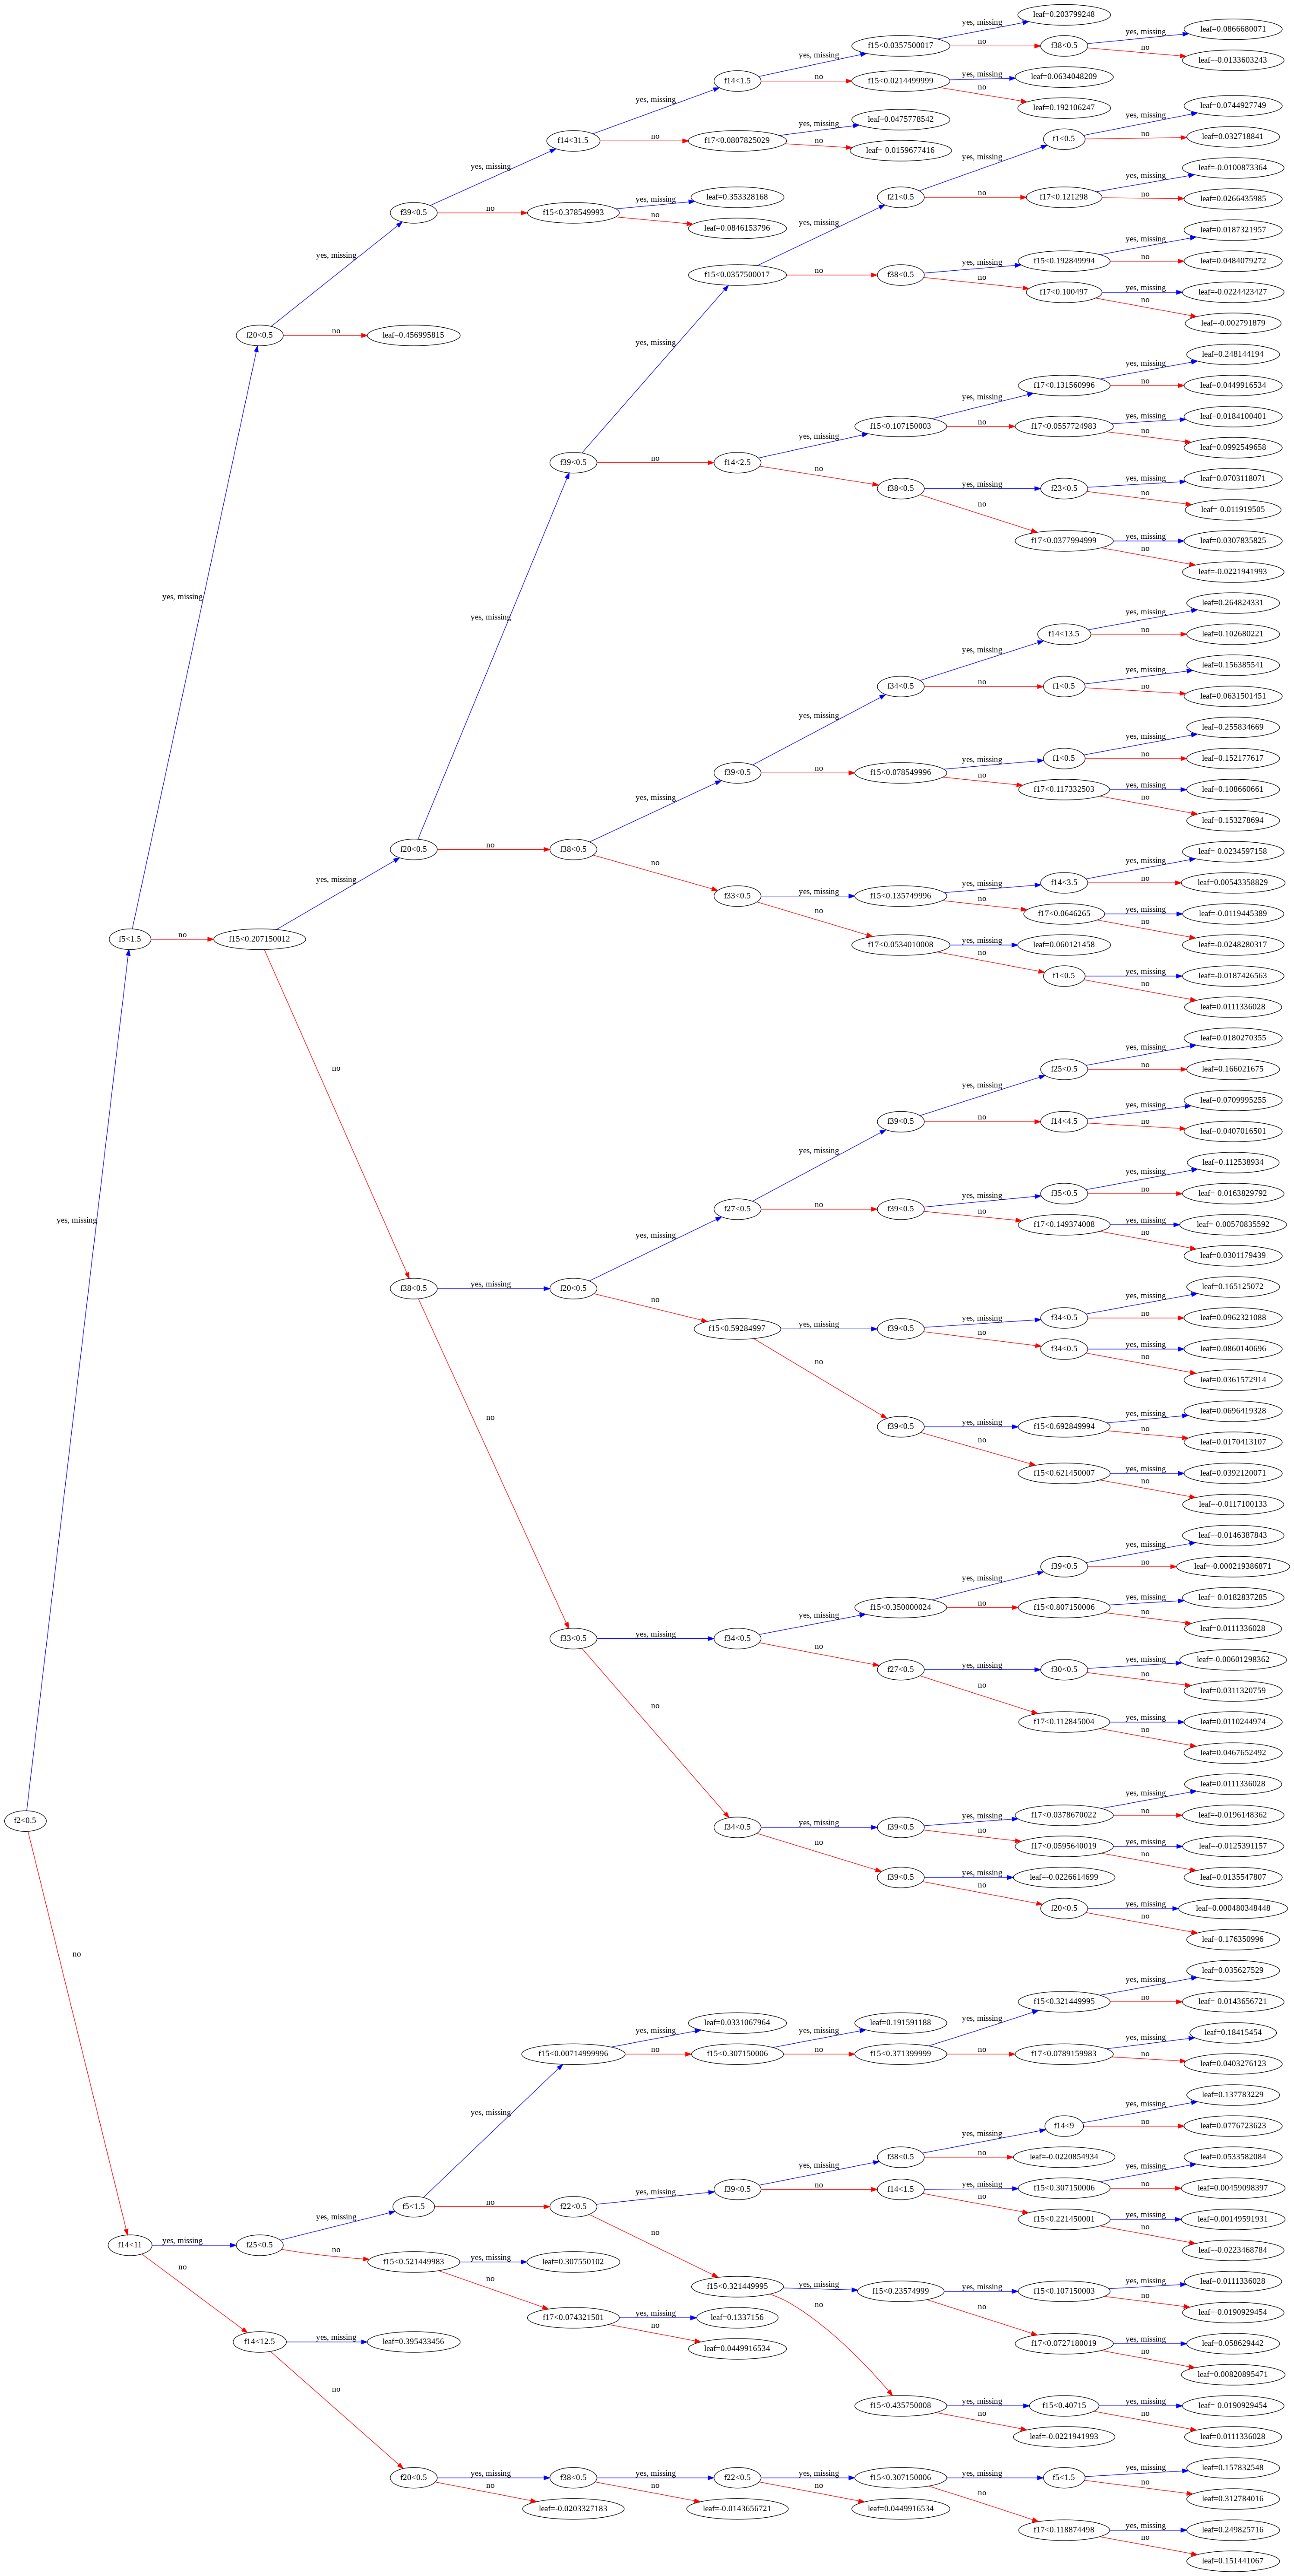

In [16]:
from xgboost import plot_tree
fig, ax = plt.subplots(figsize=(150, 150))
plot_tree(model, num_trees=0, ax=ax, rankdir='LR')
plt.savefig("tree.png")
plt.show()